In [4]:
!pip install pandas_ta

     -------------------------------------- 115.1/115.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=9f763e078f8e445284d027de3db2168bcb9a2808200fdf89b8fbfe33e0fdd4b8
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\1e\5c\47\759b32beb377aee150eb4c1f1b2b7635032cc19ea09ce076fd
Successfully built pandas_ta


In [32]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("USDCHF_Candlestick_1_D_BID_10.12.2012-10.12.2022.csv")

df.tail()

,Local time,Open,High,Low,Close,Volume
3649,06.12.2022 23:00:00.000 GMT+0100,0.94178,0.94374,0.93626,0.94036,292665.00
3650,07.12.2022 23:00:00.000 GMT+0100,0.94044,0.94263,0.93430,0.93622,234137.03
3651,08.12.2022 23:00:00.000 GMT+0100,0.93622,0.93810,0.93114,0.93307,218314.89
3652,09.12.2022 23:00:00.000 GMT+0100,0.93307,0.93307,0.93307,0.93307,0.00
3653,10.12.2022 23:00:00.000 GMT+0100,0.93307,0.93307,0.93307,0.93307,0.00


In [33]:
indexZeros = df[df['Volume']==0].index

df.drop(indexZeros, inplace=True)
df.loc[(df["Volume"]==0)]
df.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [34]:
import numpy as np
import pandas_ta as ta

df['ATR']=df.ta.atr(length=20) #Average True Range
df['RSI']=df.ta.rsi() #Relative Strength Index
df['Average']=df.ta.midprice(length=1) #Midprice
df['MA40']=df.ta.sma(length=40) #
df['MA80']=df.ta.sma(length=80) #
df['MA160']=df.ta.sma(length=160) #

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

backrollingN = 6

df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [35]:
df.tail()

,Local time,Open,High,Low,Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
3647,04.12.2022 23:00:00.000 GMT+0100,0.93847,0.94348,0.93299,0.94228,219370.52,0.010759,39.134075,0.938235,0.974256,0.973497,0.971394,-0.001184,-0.000026,-0.000074,-0.002229,-0.774524
3648,05.12.2022 23:00:00.000 GMT+0100,0.94163,0.94553,0.93802,0.94178,189151.67,0.010597,38.864602,0.941775,0.972883,0.973403,0.971266,-0.001331,-0.000047,-0.000102,-0.002206,-0.433260
3649,06.12.2022 23:00:00.000 GMT+0100,0.94178,0.94374,0.93626,0.94036,292665.00,0.010441,38.062987,0.940000,0.971460,0.973261,0.971087,-0.001401,-0.000074,-0.000126,-0.001218,0.541516
3650,07.12.2022 23:00:00.000 GMT+0100,0.94044,0.94263,0.93430,0.93622,234137.03,0.010335,35.747941,0.938465,0.969842,0.973008,0.970867,-0.001439,-0.000111,-0.000148,-0.000128,0.554593
3651,08.12.2022 23:00:00.000 GMT+0100,0.93622,0.93810,0.93114,0.93307,218314.89,0.010167,34.050945,0.934620,0.968054,0.972689,0.970616,-0.001510,-0.000168,-0.000177,-0.000545,-0.338800


In [46]:
pipdiff = 450*1e-5
SLTPRatio = 2

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None]*length
    
    for line in range (0,length-barsupfront-2):
            valueOpenLow = 0
            valueOpenHigh = 0
            for i in range(1,barsupfront+2):
                value1 = open[line+1]-low[line+i]
                value2 = open[line+1]-high[line+i]
                valueOpenLow = max(value1, valueOpenLow)
                valueOpenHigh = min(value2, valueOpenHigh)
    
                if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                    trendcat[line] = 1 #-1 downtrend
                    break
                elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                    trendcat[line] = 2 # uptrend
                    break
                else:
                    trendcat[line] = 0 # no clear trend
                
    return trendcat


In [47]:
df['mytarget'] = mytarget(16, df)
df.head()

,Local time,Open,High,Low,Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
0,09.12.2012 23:00:00.000 GMT+0100,0.93688,0.93705,0.93260,0.93346,99654.8605,NaN,NaN,0.934825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,10.12.2012 23:00:00.000 GMT+0100,0.93344,0.93688,0.93162,0.93221,109068.7012,NaN,NaN,0.934250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,11.12.2012 23:00:00.000 GMT+0100,0.93221,0.93261,0.92433,0.92621,106982.5806,NaN,NaN,0.928470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,12.12.2012 23:00:00.000 GMT+0100,0.92620,0.92750,0.92253,0.92352,108656.2494,NaN,NaN,0.925015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,13.12.2012 23:00:00.000 GMT+0100,0.92354,0.92472,0.91664,0.91725,106519.9917,NaN,NaN,0.920680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


C:\Users\Admin\AppData\Local\Temp\ipykernel_14472\3658084138.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


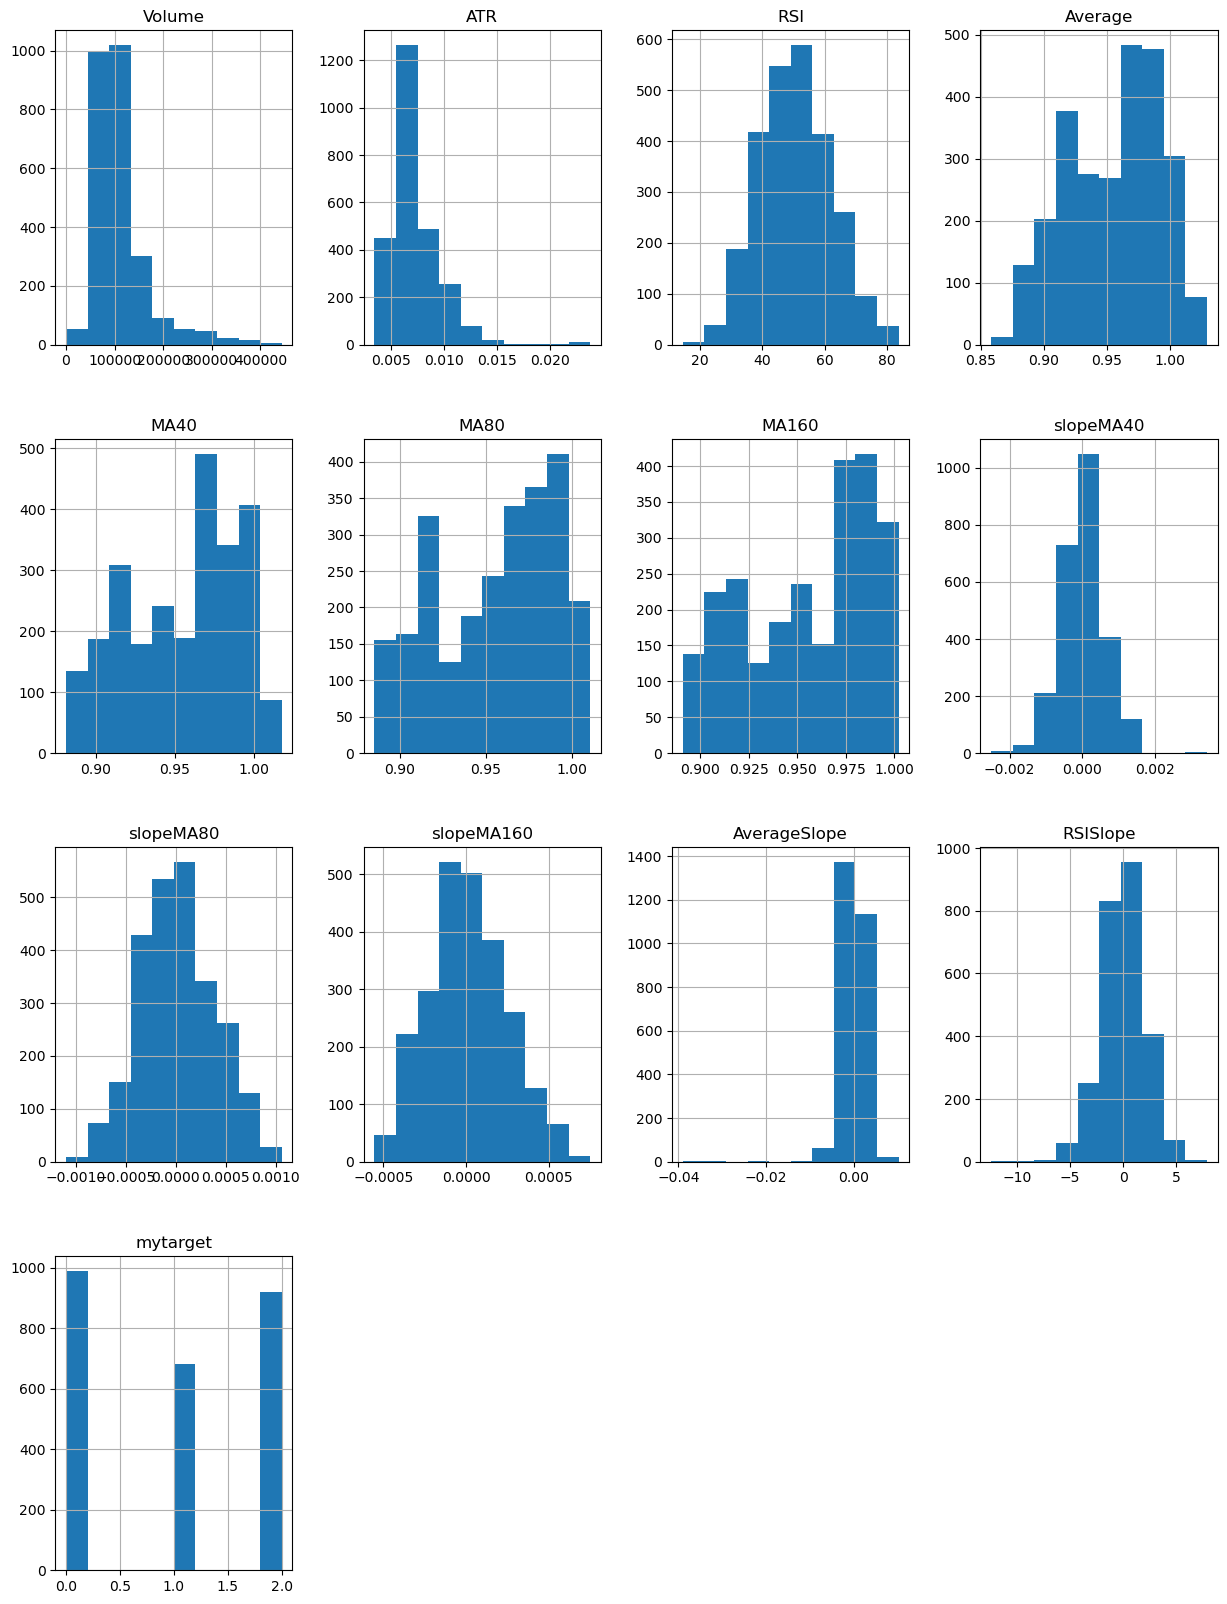

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']]
df_model.hist(ax = ax)
plt.show()

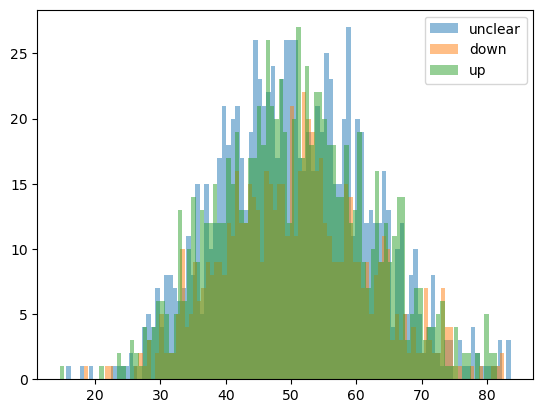

In [51]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')
pyplot.legend(loc='upper right')
pyplot.show()